# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read in Data

In [2]:
df = pd.read_csv("data/wine.csv")
df

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Customer_Segment
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,3
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,3
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,3
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,3


In [3]:
# It looks like the data has 3 labels for splitting the wine-buyerss into different customer segments
df['Customer_Segment'].unique()

array([1, 2, 3])

# K-Means Implementation

In [4]:
def get_closest_cluster(points, cluster_centers, dist_metric="L2"):
    # When dist_metric is L1, we apply L1 norm
    if dist_metric == "L1":
        order = 1
    else:
        # Default distance metric for np.linalg.norm is L2
        order = None
    return np.argmin([np.linalg.norm(points - x, axis=1, ord=order) for x in cluster_centers], axis=0)


# Given the data points and their cluster assignments, this function adjusts the cluster centers
def get_new_cluster_centers(points, cluster_assn, cluster_centers, dist_metric="L2"):
    # List of numpy arrays representing each pixel in each cluster
    data = [points[np.where(cluster_assn == x)] for x in range(len(cluster_centers))]

    # Only re-adjusting cluster centers for non-empty clusters, removing empty ones
    # by checking if len(data belonging to cluster x) > 0

    # If distance metric is L1, we use the k-median function
    if dist_metric == "L1":
        new_cluster_centers = np.array([x.median(axis=0) for x in data if len(x) > 0])
    else:
        # Otherwise, we use k-means function
        new_cluster_centers = np.array([x.mean(axis=0) for x in data if len(x) > 0])
    return new_cluster_centers


# Runs k-means algorithm on pixels
def kmeans_run(points, K, dist_metric="L2"):
    # np.random.seed(42)

    # Random initialization of K data points to be cluster centers
    old_cluster_centers = points[np.random.choice(len(points), K, replace=False)]

    # Assign each pixel to its nearest cluster
    cluster_assns = get_closest_cluster(points, old_cluster_centers, dist_metric)

    # Number of iterations, i
    i = 1

    # Do until cluster centers do not change
    while True:

        # For each cluster, calculate the new cluster centroid to be the mean
        cluster_centers = get_new_cluster_centers(points, cluster_assns, old_cluster_centers, dist_metric)

        # Assign each point to the closest cluster center
        cluster_assns = get_closest_cluster(points, cluster_centers, dist_metric)

        # Check if the cluster centers have changed; If yes, algorithm has reached convergence
        if (cluster_centers.size == old_cluster_centers.size) and (
                np.equal(cluster_centers, old_cluster_centers).sum() == old_cluster_centers.size):
            break
        i += 1

        # Storing cluster centers in variable old_cluster_centers for comparison later
        old_cluster_centers = cluster_centers

    # Only returning non-empty clusters. If an empty cluster was deleted, send a message to the user;
    k = len(cluster_centers)
    if K > k:
        print(f"Current value of K producing empty cluster. Reducing K from {K} to {k}")
    return cluster_assns, cluster_centers, i, k

# Run K-Means on Wine Data

In [5]:
data = np.array(df.drop('Customer_Segment', axis=1))
labels = np.array(df['Customer_Segment'])

In [6]:
K = 3
cluster_assns, cluster_centers, i, k = kmeans_run(data, K)

# Use PCA to Visualize Clusters

In [7]:
from sklearn.decomposition import PCA

In [8]:
pca_model = PCA(2)
reduced_data = pca_model.fit_transform(data)

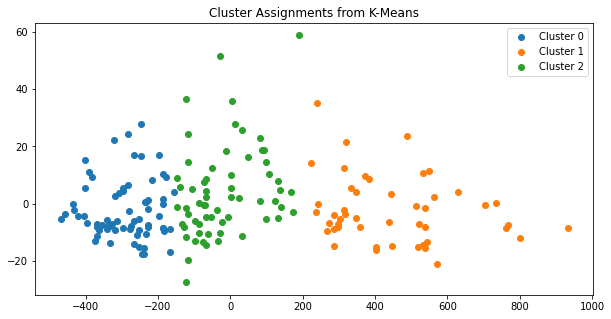

In [9]:
plt.figure(figsize=(10,5))
for cluster in range(len(cluster_centers)):
    plot_data = reduced_data[cluster_assns==cluster]
    plt.scatter(plot_data[:,0], plot_data[:,1], label=f"Cluster {cluster}")
plt.title("Cluster Assignments from K-Means")
plt.legend();

# Comparing KMeans Cluster Assignments to Customer Segments

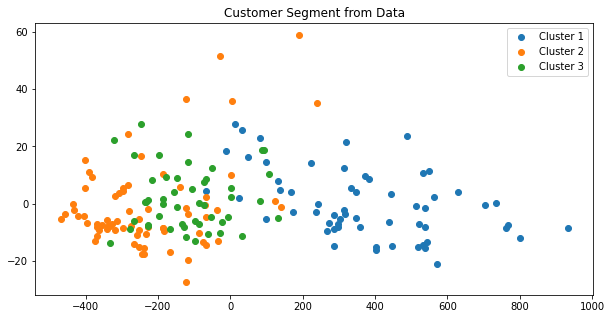

In [10]:
segments = sorted(set(labels))

plt.figure(figsize=(10,5))
for cluster in segments:
    plot_data = reduced_data[df['Customer_Segment']==cluster]
    plt.scatter(plot_data[:,0], plot_data[:,1], label=f"Cluster {cluster}")
plt.title("Customer Segment from Data")
plt.legend();

# Testing with Different Values of K

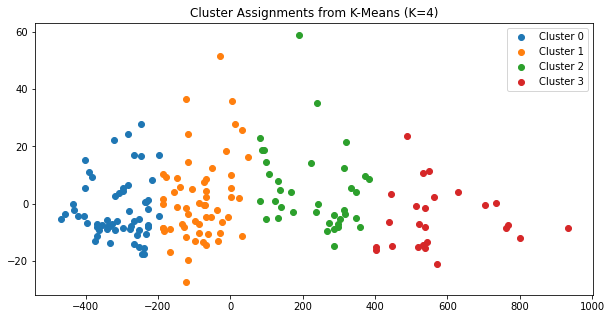

In [11]:
K = 4
cluster_assns, cluster_centers, i, k = kmeans_run(data, K)

plt.figure(figsize=(10,5))
for cluster in range(len(cluster_centers)):
    plot_data = reduced_data[cluster_assns==cluster]
    plt.scatter(plot_data[:,0], plot_data[:,1], label=f"Cluster {cluster}")
plt.title(f"Cluster Assignments from K-Means (K={K})")
plt.legend();

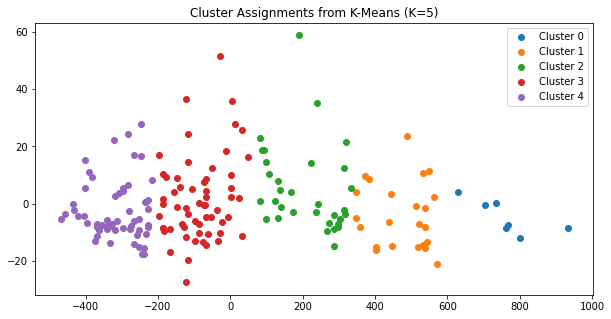

In [12]:
K = 5
cluster_assns, cluster_centers, i, k = kmeans_run(data, K)

plt.figure(figsize=(10,5))
for cluster in range(len(cluster_centers)):
    plot_data = reduced_data[cluster_assns==cluster]
    plt.scatter(plot_data[:,0], plot_data[:,1], label=f"Cluster {cluster}")
plt.title(f"Cluster Assignments from K-Means (K={K})")
plt.legend();

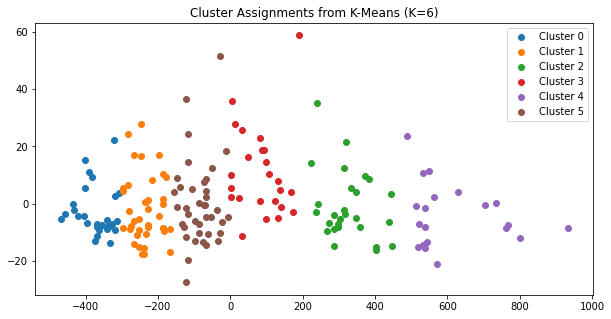

In [13]:
K = 6
cluster_assns, cluster_centers, i, k = kmeans_run(data, K)

plt.figure(figsize=(10,5))
for cluster in range(len(cluster_centers)):
    plot_data = reduced_data[cluster_assns==cluster]
    plt.scatter(plot_data[:,0], plot_data[:,1], label=f"Cluster {cluster}")
plt.title(f"Cluster Assignments from K-Means (K={K})")
plt.legend();